In [4]:
import sys
from PCA import PCA
from IsolationForest import IsolationForest
from preprocessing import FeatureExtractor
import fasttext
from tokenizer import my_tokenize
import numpy as np
import pandas as pd

ft = fasttext.load_model("fasttext_model/mix.bin")

train_file = "input/training_k3s.txt"
test_file = "input/dec15_k3s.txt"

train_file = "input/newk3s1-train"
test_file = "input/newk3s1-test"
def get_train_test():
    
    print('Loading phase:')
    train_vecs = load_data(train_file)
    test_vecs = load_data(test_file)
    return train_vecs, test_vecs

def l2_norm(x):
   return np.sqrt(np.sum(x**2))
def div_norm(x):
   norm_value = l2_norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x
def get_sentence_vector(tokens):
    wordvecs_split = [ft[word] for word in tokens]
    processed_word_vectors = []
    for word_vector in wordvecs_split:
        processed_word_vectors.append(div_norm(word_vector))
    processed_word_vectors = np.array(processed_word_vectors)
    return np.mean(processed_word_vectors,axis=0)

def load_data(filepath):
    import random
    print("tokenizing file :" + str(filepath))
    d = []
    with open(filepath, 'r') as fin:
        for idx, line in enumerate(fin):
            d.append(line)
    res = []
    #random.shuffle(d)
    for line in d:
        tokens = my_tokenize(line.lower().rstrip())
        #vecs = [ft[t] for t in tokens if t in ft]
        vecs = get_sentence_vector(tokens)
        res.append(vecs)
    
    return np.array(res)


train_vecs,test_vecs = get_train_test() ## get the word embeddings 


Loading phase:
tokenizing file :input/newk3s1-train
tokenizing file :input/newk3s1-test


In [ ]:
def run_pca(train_vecs,test_vecs):
    

    print('Train phase:')
    feature_extractor = FeatureExtractor()
    x_train = feature_extractor.fit_transform(train_vecs, normalization='zero-mean')
    model = PCA() 
   model.fit(x_train)
    y_train = model.predict(x_train)

    print('Test phase:')
    x_test = feature_extractor.transform(test_vecs) 
    y_test = model.predict(x_test)
    return y_train, y_test

def run_iforest(train_vecs,test_vecs):
    from sklearn import ensemble
    anomaly_ratio = 0.01

    print('Train phase:')
    feature_extractor = FeatureExtractor()
    x_train = feature_extractor.fit_transform(train_vecs, normalization='zero-mean')
    x_test = feature_extractor.transform(test_vecs)

    #model = ensemble.IsolationForest(contamination=anomaly_ratio)
    model = IsolationForest()
    model.fit(x_train)

    y_train = model.predict(x_train)

    y_test = model.predict(x_test)
    return y_train, y_test


#y_train, y_test = run_pca(train_vecs,test_vecs)
#y_train, y_test = run_iforest(train_vecs,test_vecs)

In [5]:
## this block is for GMM

#feature_extractor = FeatureExtractor()
#x_train = feature_extractor.fit_transform(train_vecs)
#x_test = feature_extractor.transform(test_vecs)
x_train = train_vecs
x_test = test_vecs

from sklearn.mixture import GaussianMixture
ct = "full" ## ‘full’, ‘tied’, ‘diag’, ‘spherical’
gmm = GaussianMixture(covariance_type=ct,n_components=200)
gmm.fit(x_train) # train model

def get_anomaly(y_pred):
    y_final = []
    for probs_idx in range(len(y_pred)):
        sample_probs = y_pred[probs_idx]
        ones_prob = np.ones_like(sample_probs)
        diff_probs = ones_prob - sample_probs
        final_probability = 1.0 - np.prod(diff_probs)
        y_final.append(final_probability)
#         y_final.append(max(y_pred[probs_idx]))
#     y_final = [1 if y <= 0.8 else 0 for y in y_final]
    return y_final

y_train = gmm.predict_proba(x_train) ## get predit
y_test = gmm.predict_proba(x_test)

y_train_anomaly = get_anomaly(y_train)
y_test_anomaly = get_anomaly(y_test)

threshold = np.quantile(y_train_anomaly,0.05) ## compute threshold

y_train_pred = [1 if yt < threshold else 0 for yt in y_train_anomaly]
y_test_pred = [1 if yt < threshold else 0 for yt in y_test_anomaly]

sum(y_train_pred), sum(y_test_pred)        

(10540, 25114)

In [13]:
## read csv file and plot the results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
old_test = "input/k3s_test_pred.csv"
old_train = "input/k3s_train_pred.csv"
new_test = "input/newk3s1-test.csv"
filename = new_test
df = pd.read_csv(filename, parse_dates=True, index_col = "timestamp")

In [14]:
# import pandas as pd

# # old_test = "input/k3s_test_pred.csv"
# # old_train = "input/k3s_train_pred.csv"
# # df_train = pd.read_csv(file_train)
# # df_test = pd.read_csv(file_test)

# nulog_train = "input/train.txt"
# nulog_test = "input/test.txt"

# def read_txt(filename):
#     res = []
#     with open(filename, 'r') as fin:
#         for line in fin:
#             score = float(line)
#             res.append(1 if score < 0.8 else 0)
#     return res
# nulog_train_res = read_txt(nulog_train)
# nulog_test_res = read_txt(nulog_test)

# df["nulog_anomaly"] = nulog_test_res
# df.to_csv(filename)

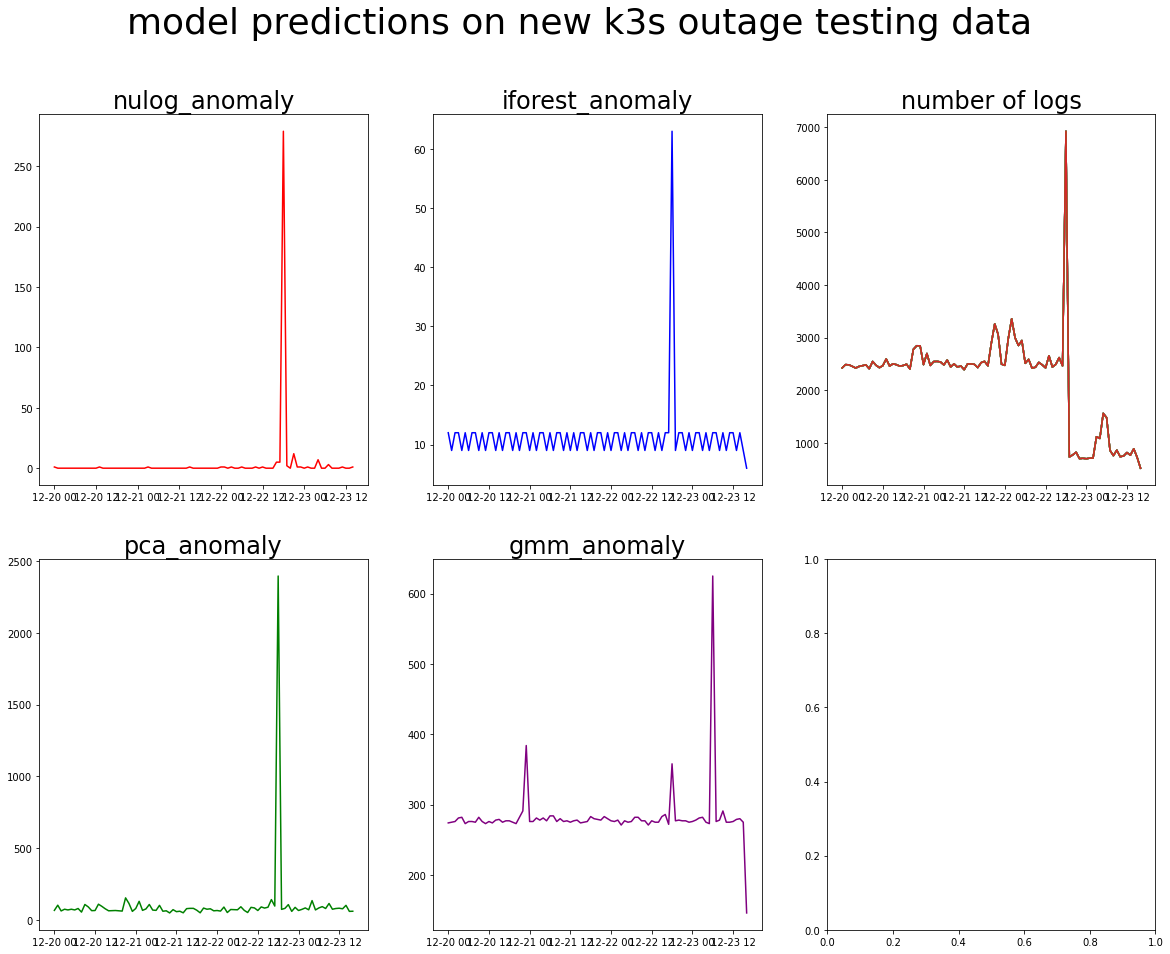

In [15]:
import matplotlib.pyplot as plt
fig, axe = plt.subplots(nrows=2, ncols=3,figsize=(20, 15))

timescale = "1H"

fig.suptitle("model predictions on new k3s outage testing data", fontsize= 36)
axe[0,2].plot(df.resample(timescale).count())
axe[0,2].set_title("number of logs", fontsize=24)

## nulog preds
fields = "nulog_anomaly"
df1 = df[df[fields]==1]
#df1.resample(timescale).count()[fields].plot(color="Red")
p1 = df1.resample(timescale).count()[fields]
axe[0, 0].plot(p1, color="Red")
axe[0, 0].set_title(fields, fontsize=24)
## drain preds
fields2 = "drain_anomaly"
df2 = df[df[fields2]==1]
#df2.resample(timescale).count()[fields2].plot(color="Blue")
p2 = df2.resample(timescale).count()[fields2]
# axe[0, 1].plot(p2, color="Blue")
# axe[0, 1].set_title(fields2, fontsize=24)

## pca preds
fields3 = "pca_anomaly"
if fields3 in df:
    df3 = df[df[fields3]==1.0]
    #df3.resample(timescale).count()[fields3].plot(color="Green")
    p3 = df3.resample(timescale).count()[fields3]
    axe[1, 0].plot(p3, color="Green")
    axe[1, 0].set_title(fields3, fontsize=24)
    
## iforest
fields4 = "iforest_anomaly"
if fields4 in df:
    df4 = df[df[fields4]==1]
    #df4.resample(timescale).count()[fields4].plot(color="Yellow")
    p4 = df4.resample(timescale).count()[fields4]
    axe[0, 1].plot(p4, color="Blue")
    axe[0, 1].set_title(fields4, fontsize=24)
timescale = "1H"

# gmm
fields5 = "gmm_anomaly" # "iforest_anomaly" "gmm_anomaly"
if fields5 in df:
    df5 = df[df[fields5]==1]
#     df5.resample(timescale).count()[fields5].plot(color="Purple")
    p5 = df5.resample(timescale).count()[fields5]
    axe[1, 1].plot(p5, color="Purple")
    axe[1, 1].set_title(fields5, fontsize=24)
